## Epsilon Optimization
Finding the optimal epsilon value for fmin_slsqp

The results were generated with a code change in PEQ that allows specifying epsilon values. Since the results clearly show that adjusting epsilon does not give any benefits, the changes were removed.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
from time import time
from copy import deepcopy
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from peq import PEQ
from constants import DEFAULT_FS, PEQ_CONFIGS

In [3]:
def rmse(fr, eq):
    ix10k = np.argmin(np.abs(10000 - fr.frequency))
    return np.sqrt(np.mean(np.square(fr.equalization[:ix10k] - eq[:ix10k])))

In [4]:
def extend_config(config, **optimizer_kwargs):
    config2 = deepcopy(config)
    if 'optimizer' not in config2:
        config2['optimizer'] = dict(**optimizer_kwargs)
    else:
        config2['optimizer'].update(dict(**optimizer_kwargs))
    return config2

In [35]:
def plot_loss_time_vs_epsilon(epsilons, configs, max_n=None):
    mean_times = []
    max_times = []
    mean_rmses = []
    max_rmses = []
    base_times = dict()
    base_rmses = dict()
    
    n = 0
    for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
        fr = FrequencyResponse.read_from_csv(fp)
        t = time()
        peqs = fr.optimize_parametric_eq(configs, DEFAULT_FS, max_time=5)
        base_times[fp.name] = time() - t
        base_rmses[fp.name] = np.min(peqs[-1].history.loss)
        n += 1
        if max_n is not None and n == max_n:
            break
    
    for epsilon in epsilons:
        configs = [extend_config(config, epsilon=epsilon) for config in configs]
        n = 0
        inner_times = []
        inner_rmses = []
        for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
            fr = FrequencyResponse.read_from_csv(fp)
            t = time()
            peqs = fr.optimize_parametric_eq(configs, DEFAULT_FS, max_time=5)
            inner_times.append((time() - t) / base_times[fp.name])
            inner_rmses.append(np.min(peqs[-1].history.loss) / base_rmses[fp.name])
            n += 1
            if max_n is not None and n == max_n:
                break
        mean_times.append(np.mean(inner_times))
        max_times.append(np.quantile(inner_times, 0.9))
        mean_rmses.append(np.mean(inner_rmses))
        max_rmses.append(np.quantile(inner_rmses, 0.9))
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    ax.plot(epsilons, np.array(mean_times) * 100, label='Avg time')
    ax.plot(epsilons, np.array(max_times) * 100, label='90% time')
    ax.plot(epsilons, np.array(mean_rmses) * 100, label='Avg RMSE')
    ax.plot(epsilons,np.array( max_rmses) * 100, label='90% RMSE')
    ax.semilogx()
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('%')
    ax.legend()
    ax.grid()
    plt.show()

In [36]:
epsilons = np.concatenate([[0.0], 2**np.linspace(np.log2(0.0001), np.log2(0.1), 15)]).tolist()

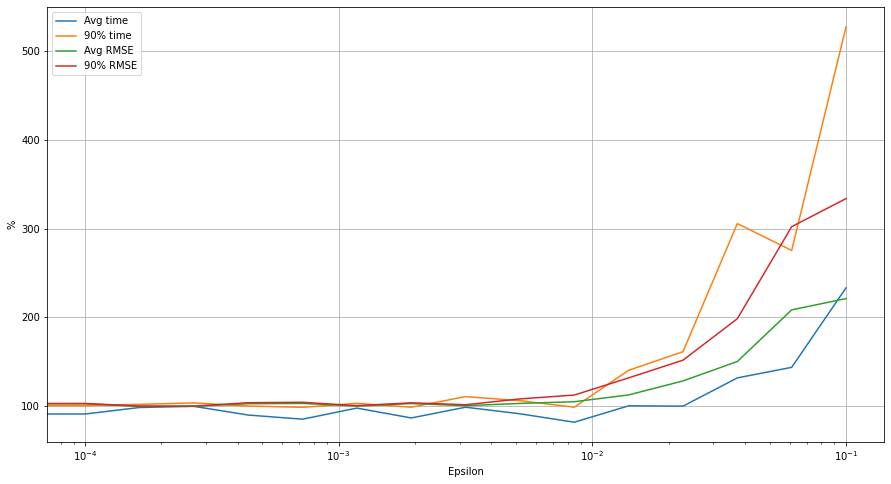

In [38]:
plot_loss_time_vs_epsilon(epsilons, [PEQ_CONFIGS['4_PEAKING_WITH_LOW_SHELF']], max_n=10)

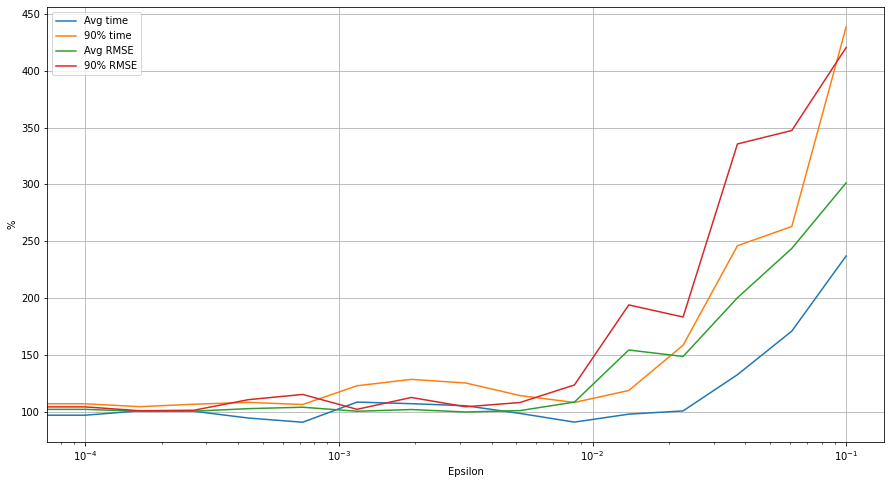

In [39]:
plot_loss_time_vs_epsilon(epsilons, [PEQ_CONFIGS['4_PEAKING_WITH_LOW_SHELF'], PEQ_CONFIGS['4_PEAKING_WITH_HIGH_SHELF']], max_n=10)

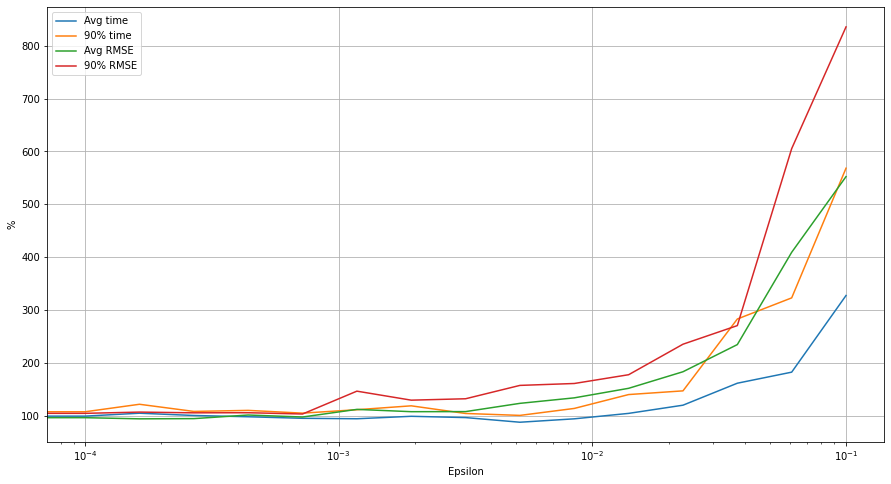

In [40]:
plot_loss_time_vs_epsilon(epsilons, [PEQ_CONFIGS['8_PEAKING_WITH_SHELVES']], max_n=10)

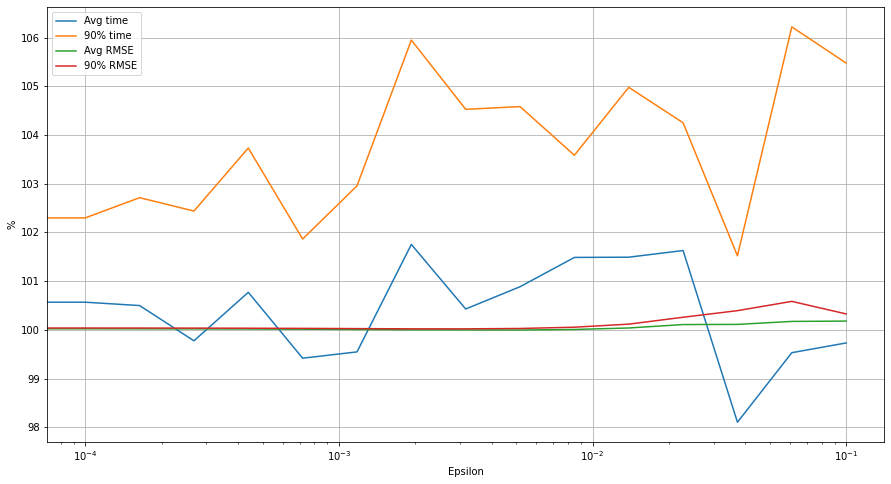

In [41]:
plot_loss_time_vs_epsilon(epsilons, [PEQ_CONFIGS['10_BAND_GRAPHIC_EQ']], max_n=10)